In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, LeakyReLU, Dropout, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, GlobalAvgPool2D, PReLU)
from tensorflow.keras.optimizers import Adam

# Data Downloading

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d badasstechie/celebahq-resized-256x256
! unzip "/content/celebahq-resized-256x256.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/celeba_hq_256/25000.jpg  
  inflating: /content/dataset/celeba_hq_256/25001.jpg  
  inflating: /content/dataset/celeba_hq_256/25002.jpg  
  inflating: /content/dataset/celeba_hq_256/25003.jpg  
  inflating: /content/dataset/celeba_hq_256/25004.jpg  
  inflating: /content/dataset/celeba_hq_256/25005.jpg  
  inflating: /content/dataset/celeba_hq_256/25006.jpg  
  inflating: /content/dataset/celeba_hq_256/25007.jpg  
  inflating: /content/dataset/celeba_hq_256/25008.jpg  
  inflating: /content/dataset/celeba_hq_256/25009.jpg  
  inflating: /content/dataset/celeba_hq_256/25010.jpg  
  inflating: /content/dataset/celeba_hq_256/25011.jpg  
  inflating: /content/dataset/celeba_hq_256/25012.jpg  
  inflating: /content/dataset/celeba_hq_256/25013.jpg  
  inflating: /content/dataset/celeba_hq_256/25014.jpg  
  inflating: /content/dataset/celeba_hq_256/25015.jpg  
  inflating: /content/dataset/celeba_hq_256/25016.jpg

# Data Loading

In [ ]:
BATCH_SIZE = 128
IMG_SHAPE = (64, 64, 3)
B = 24
LEARNING_RATE = 1e-4

In [ ]:
data_directory = "/content/dataset/celeba_hq_256"

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
dataset = image_dataset_from_directory(data_directory,
                                      label_mode = None,
                                      image_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
                                      batch_size = BATCH_SIZE)

Found 30000 files belonging to 1 classes.


In [ ]:
def preprocess(image):
  return tf.image.resize(image, [IMG_SHAPE[0] // 4, IMG_SHAPE[1] // 4], method='bicubic') / 255, tf.cast(image, tf.float32) / 127.5 - 1

In [ ]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
train_dataset = (dataset
                .map(preprocess)
                .unbatch()
                .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
                .batch(BATCH_SIZE, drop_remainder=True)
                .prefetch(tf.data.AUTOTUNE))

In [ ]:
for image_1, image_2 in train_dataset.take(1):
  print(image_1.shape, image_2.shape)

(128, 16, 16, 3) (128, 64, 64, 3)


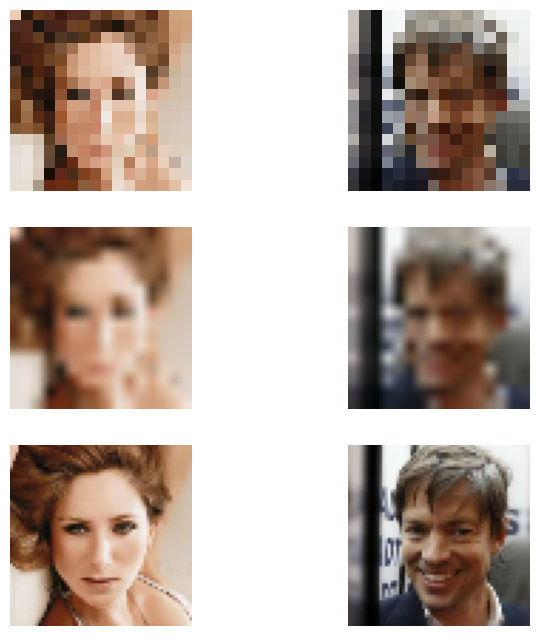

In [ ]:
plt.figure(figsize=(8, 8))
n = 6
for i in range(n):
  ax = plt.subplot(3, 2, i+1)
  if i < 2:
    plt.imshow(image_1[i])
  elif i>=2 and i<4:
    plt.imshow(cv2.resize(np.array(image_1[i-2]), (64, 64)))
  else:
    plt.imshow((image_2[i-4] + 1) / 2)
  plt.axis("off")

# Generator Modeling

In [ ]:
@tf.keras.utils.register_keras_serializable()
class ResBlock(Layer):
  def __init__(self, n_filters, filter_size, strides, name='res_block'):
    super(ResBlock, self).__init__(name=name)
    self.n_filters = n_filters
    self.filter_size = filter_size
    self.strides = strides

  def build(self, input_shape):
    self.conv_1 = Conv2D(self.n_filters, self.filter_size, self.strides, padding='same')
    self.batch_norm_1 = BatchNormalization()
    self.prelu = PReLU()
    self.conv_2 = Conv2D(self.n_filters, self.filter_size, self.strides, padding='same')
    self.batch_norm_2 = BatchNormalization()

  def call(self, x_in):
    x = self.conv_1(x_in)
    x = self.prelu(self.batch_norm_1(x))
    x = self.conv_2(x)
    x = self.batch_norm_2(x)
    return x + x_in

  def get_config(self):
    config = super(ResBlock, self).get_config()
    config.update({
        'n_filters': self.n_filters,
        'filter_size': self.filter_size,
        'strides': self.strides
    })
    return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class UpsampleBlock(Layer):
  def __init__(self, n_filters, filter_size, strides, name='upsample_block'):
    super(UpsampleBlock, self).__init__(name=name)
    self.n_filters = n_filters
    self.filter_size = filter_size
    self.strides = strides

  def build(self, input_shape):
    self.conv = Conv2D(self.n_filters, self.filter_size, self.strides, padding='same')
    self.prelu = PReLU()

  def call(self, x):
    x = self.conv(x)
    x = tf.nn.depth_to_space(x, 2)
    x = self.prelu(x)
    return x

  def get_config(self):
    config = super(UpsampleBlock, self).get_config()
    config.update({
        'n_filters': self.n_filters,
        'filter_size': self.filter_size,
        'strides': self.strides
    })
    return config

In [ ]:
input_lr = tf.keras.layers.Input(shape=(IMG_SHAPE[0] // 4, IMG_SHAPE[1]//4, 3))
input_conv = tf.keras.layers.Conv2D(64, 9, 1, padding='same')(input_lr)
input_conv = PReLU()(input_conv)

x = input_conv
for i in range(B):
  x = ResBlock(64, 3, 1, name='res_block_' + str(i))(x)

x = tf.keras.layers.Conv2D(64, 9, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = x + input_conv

x = UpsampleBlock(256, 3, 1, name='upsample_block_1')(x)
x = UpsampleBlock(256, 3, 1, name='upsample_block_2')(x)

output_lr = tf.keras.layers.Conv2D(3, 9, activation='tanh', padding='same')(x)

srresnet = tf.keras.models.Model(input_lr, output_lr)

In [ ]:
srresnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 16, 16, 64)           16384     ['conv2d[0][0]']              
                                                                                                  
 res_block_0 (ResBlock)      (None, 16, 16, 64)           90752     ['p_re_lu[0][0]']             
                                                                                              

In [ ]:
@tf.keras.utils.register_keras_serializable()
class ConvBlock(Layer):
  def __init__(self, n_filters, filter_size, strides, name='conv_block'):
    super(ConvBlock, self).__init__(name=name)
    self.n_filters = n_filters
    self.filter_size = filter_size
    self.strides = strides

  def build(self, input_shape):
    self.conv = Conv2D(self.n_filters, self.filter_size, self.strides, padding='same')
    self.batch_norm = BatchNormalization()

  def call(self, x):
    x = self.conv(x)
    x = LeakyReLU()(self.batch_norm(x))
    return x

  def get_config(self):
    config = super(ConvBlock, self).get_config()
    config.update({
        'n_filters': self.n_filters,
        'filter_size': self.filter_size,
        'strides': self.strides
    })
    return config

In [ ]:
input_lr = Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
input_conv = Conv2D(64, 3, padding='same')(input_lr)
input_conv = LeakyReLU()(input_conv)

channel_nums = [64, 128, 128, 256, 256, 512, 512]
stride_sizes = [2, 1, 2, 1, 2, 1, 2]

disc = input_conv
for i in range(7):
  disc = ConvBlock(channel_nums[i],3,stride_sizes[i],name='conv_block_'+str(i))(disc)

disc = GlobalAvgPool2D()(disc)
disc = Dense(1024)(disc)
disc = LeakyReLU()(disc)

disc_output = Dense(1, activation='sigmoid')(disc)

discriminator = Model(input_lr, disc_output)

In [ ]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv_block_0 (ConvBlock)    (None, 32, 32, 64)        37184     
                                                                 
 conv_block_1 (ConvBlock)    (None, 32, 32, 128)       74368     
                                                                 
 conv_block_2 (ConvBlock)    (None, 16, 16, 128)       148096    
                                                                 
 conv_block_3 (ConvBlock)    (None, 16, 16, 256)       2961

In [ ]:
def pixel_MSE(y_true, y_pred):
  return tf.reduce_mean((y_true - y_pred) ** 2)

In [ ]:
VGG19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
def VGG_loss(y_hr, y_sr,i_m=2, j_m=2):
  i, j = 0, 0
  accumulated_loss = 0.0
  for layer in VGG19.layers:
    cl_name = layer.__class__.__name__
    if cl_name == 'Conv2D':
      j=j+1
    if cl_name == 'MaxPooling2D':
      i=i+1
      j=0
    if i==i_m and j==j_m:
      break

    y_hr = layer(y_hr)
    y_sr = layer(y_sr)
    if cl_name == 'Conv2D':
      mse = MeanSquaredError(name='mean_squared_error')
      accumulated_loss = accumulated_loss + mse(y_hr, y_sr) * 0.006
  return accumulated_loss

In [ ]:
def content_loss(y_true, y_pred):
  mse = MeanSquaredError(name='mean_squared_error')
  return mse(y_true, y_pred) + VGG_loss(y_true, y_pred)

In [ ]:
class GANMonitor(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch,logs=None):
    plt.figure(figsize = (16,16))
    k=0
    n = 6
    for i in range(n):
      ax = plt.subplot(3,2, k+1)
      if i<2:
        plt.imshow(image_1[i])
      elif i>=2 and i<4:
        out=self.model.generator(tf.expand_dims(image_1[i-2],axis=0))
        plt.imshow((out[0]+1)/2)
      else:
        plt.imshow((image_2[i-4]+1)/2)
      plt.axis("off")
      k+=1
      plt.close()

    plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SRGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(SRGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_disc,loss_gen,):
        super(SRGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_disc=loss_disc
        self.loss_gen=loss_gen
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

      lr_images,hr_images = real_images

      batch_size = tf.shape(hr_images)[0]

      generated_images = self.generator(lr_images)

      real_labels = tf.ones((batch_size, 1))
      fake_labels = tf.zeros((batch_size, 1))

      # Train the discriminator
      with tf.GradientTape() as tape:

          real_predictions = self.discriminator(hr_images)
          d_loss_real = self.loss_disc(real_labels,real_predictions)

          fake_predictions = self.discriminator(generated_images)
          d_loss_fake = self.loss_disc(fake_labels,fake_predictions)

          d_loss = 0.5*(d_loss_fake+d_loss_real)
      grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

      misleading_labels = tf.ones((batch_size, 1))

      with tf.GradientTape() as tape:
          predictions = self.generator(lr_images)
          g_loss = self.loss_gen(hr_images, predictions)
          g_loss=g_loss+1e-3*self.loss_disc(misleading_labels, self.discriminator(predictions))

      grads = tape.gradient(g_loss, self.generator.trainable_weights)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

      # Update metrics
      self.d_loss_metric.update_state(d_loss)
      self.g_loss_metric.update_state(g_loss)
      return {
          "d_loss": self.d_loss_metric.result(),
          "g_loss": self.g_loss_metric.result(),
      }

    def get_config(self):
      config = super(SRGAN, self).get_config()
      config.update({
          'd_optimizer': self.d_optimizer,
          'g_optimizer': self.g_optimizer,
          'loss_disc': self.loss_disc,
          'loss_gen': self.loss_gen,
      })
      return config

In [ ]:
! mkdir generated

mkdir: cannot create directory ‘generated’: File exists


In [ ]:
epochs = 36

gan = SRGAN(discriminator=discriminator, generator=srresnet)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_disc=tf.keras.losses.BinaryCrossentropy(),
    loss_gen=content_loss,
)

Epoch 1/10
234/234 [==============================] - 173s 732ms/step - d_loss: 0.1160 - g_loss: 0.2172
Epoch 2/10
234/234 [==============================] - 170s 721ms/step - d_loss: 0.0449 - g_loss: 0.1894
Epoch 3/10
234/234 [==============================] - 173s 734ms/step - d_loss: 0.0564 - g_loss: 0.1730
Epoch 4/10
234/234 [==============================] - 171s 727ms/step - d_loss: 0.1383 - g_loss: 0.1620
Epoch 5/10
234/234 [==============================] - 169s 721ms/step - d_loss: 0.0394 - g_loss: 0.1571
Epoch 6/10
234/234 [==============================] - 170s 723ms/step - d_loss: 0.0392 - g_loss: 0.1527
Epoch 7/10
234/234 [==============================] - 170s 725ms/step - d_loss: 0.1961 - g_loss: 0.1485
Epoch 8/10
234/234 [==============================] - 171s 726ms/step - d_loss: 0.0652 - g_loss: 0.1435
Epoch 9/10
234/234 [==============================] - 171s 727ms/step - d_loss: 0.0560 - g_loss: 0.1418
Epoch 10/10
234/234 [==============================] - 170s 723m

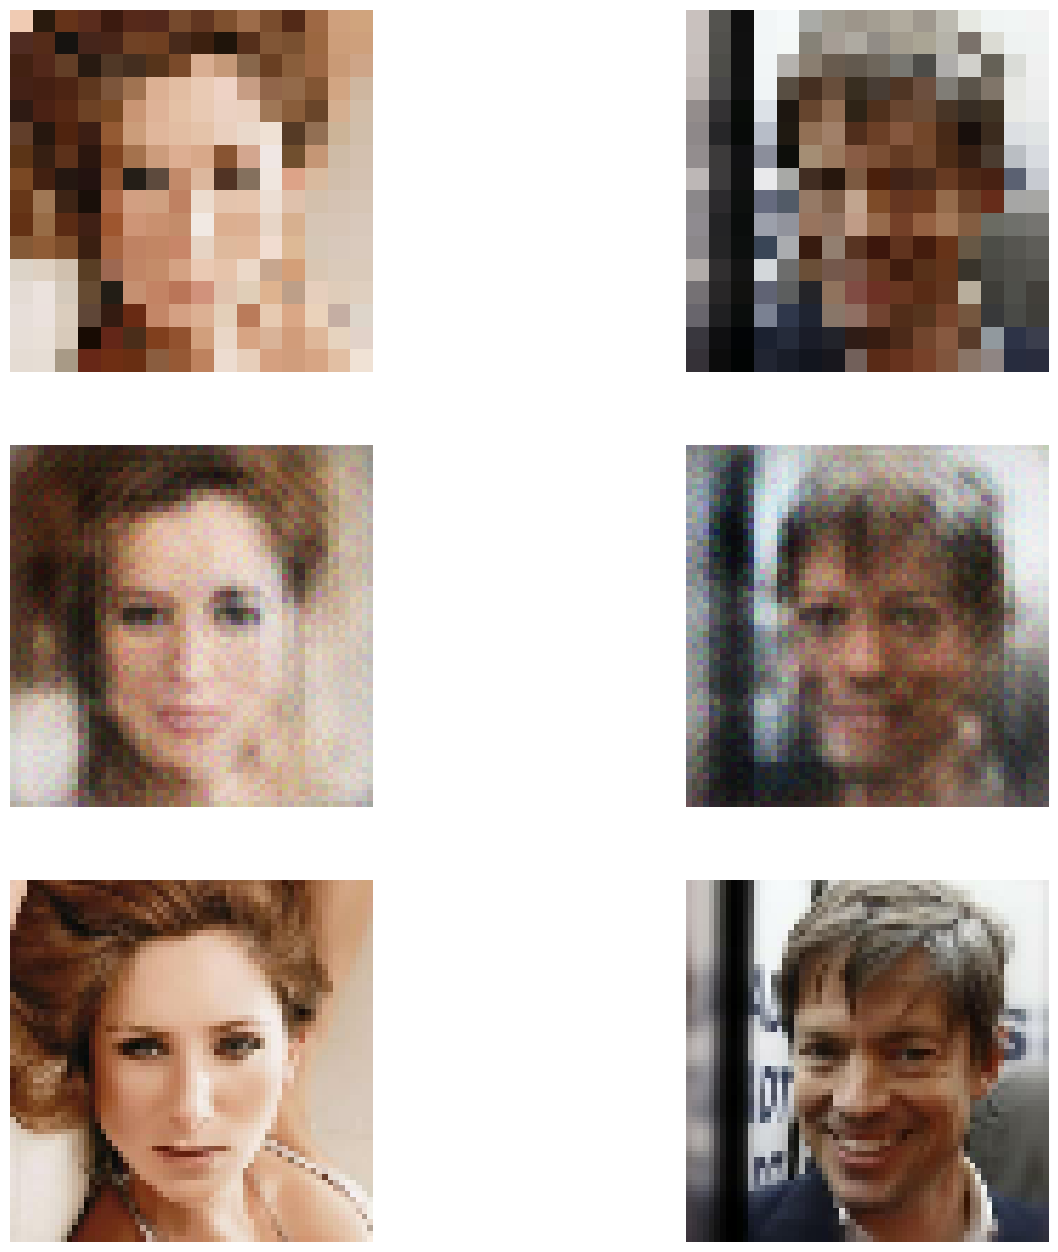

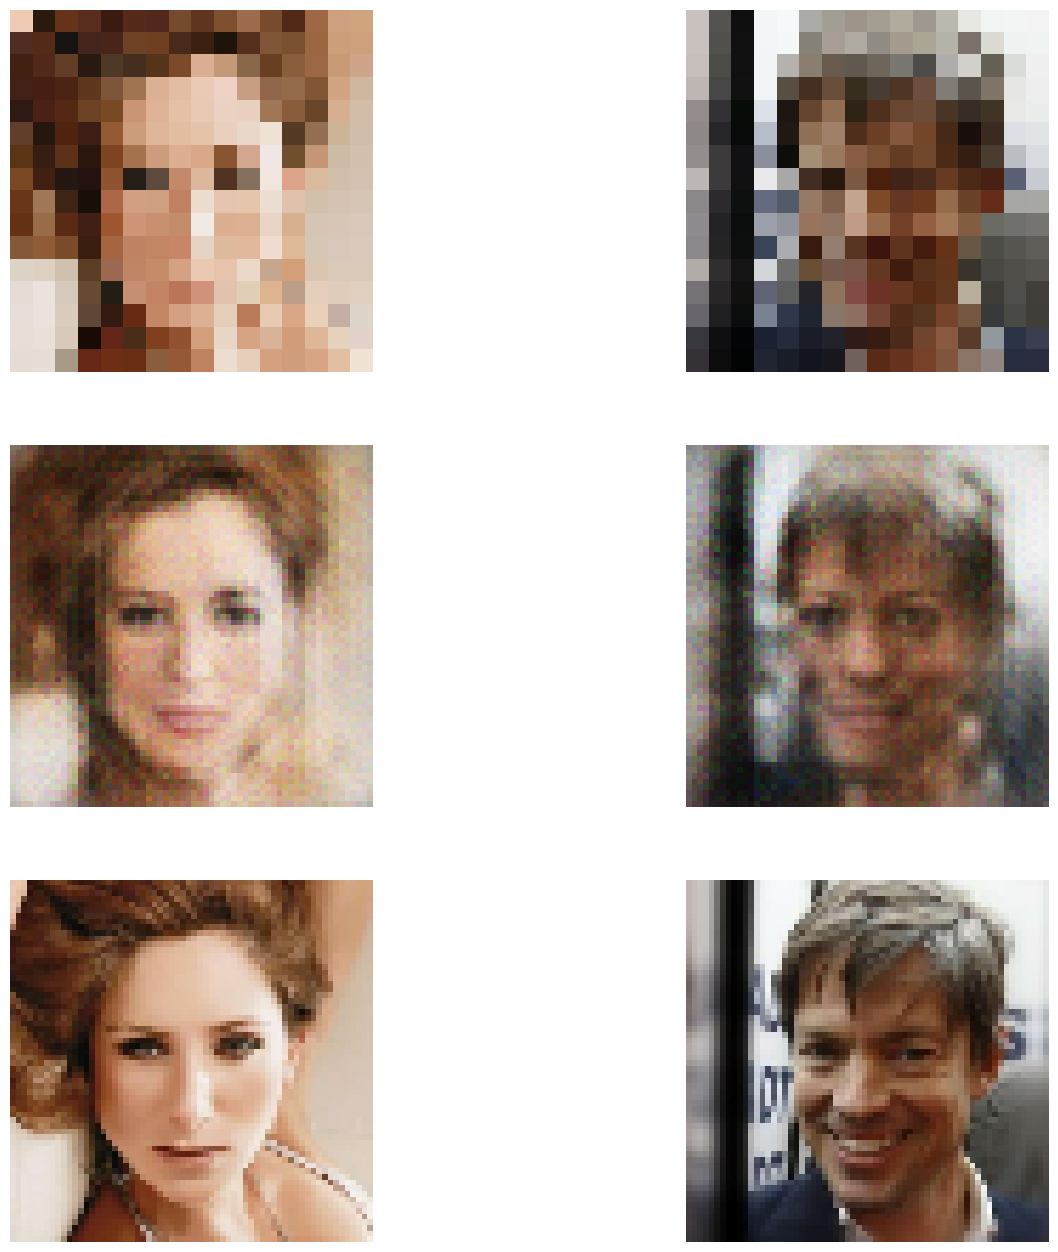

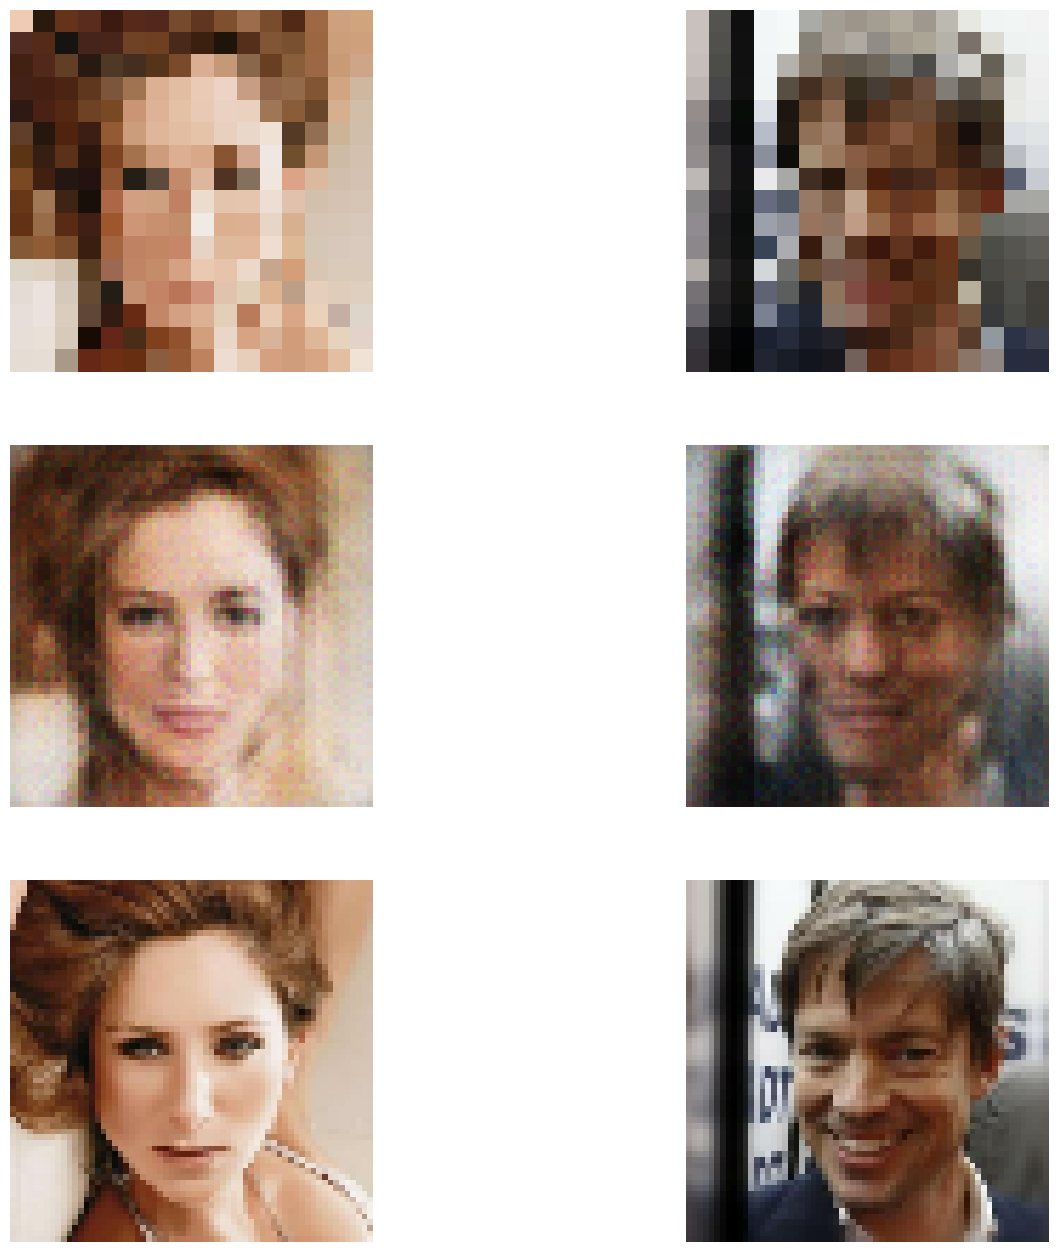

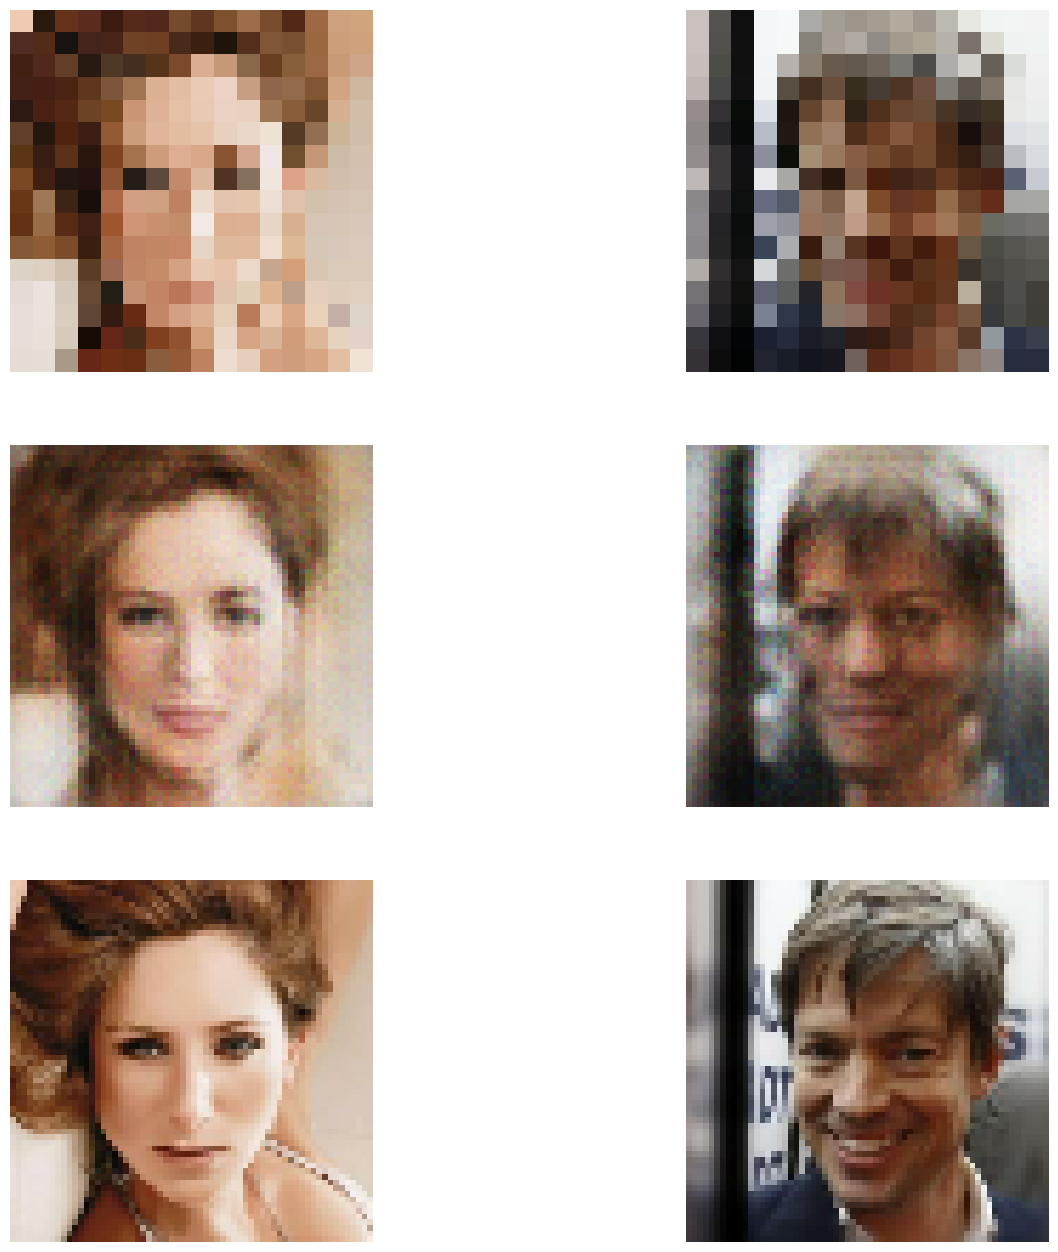

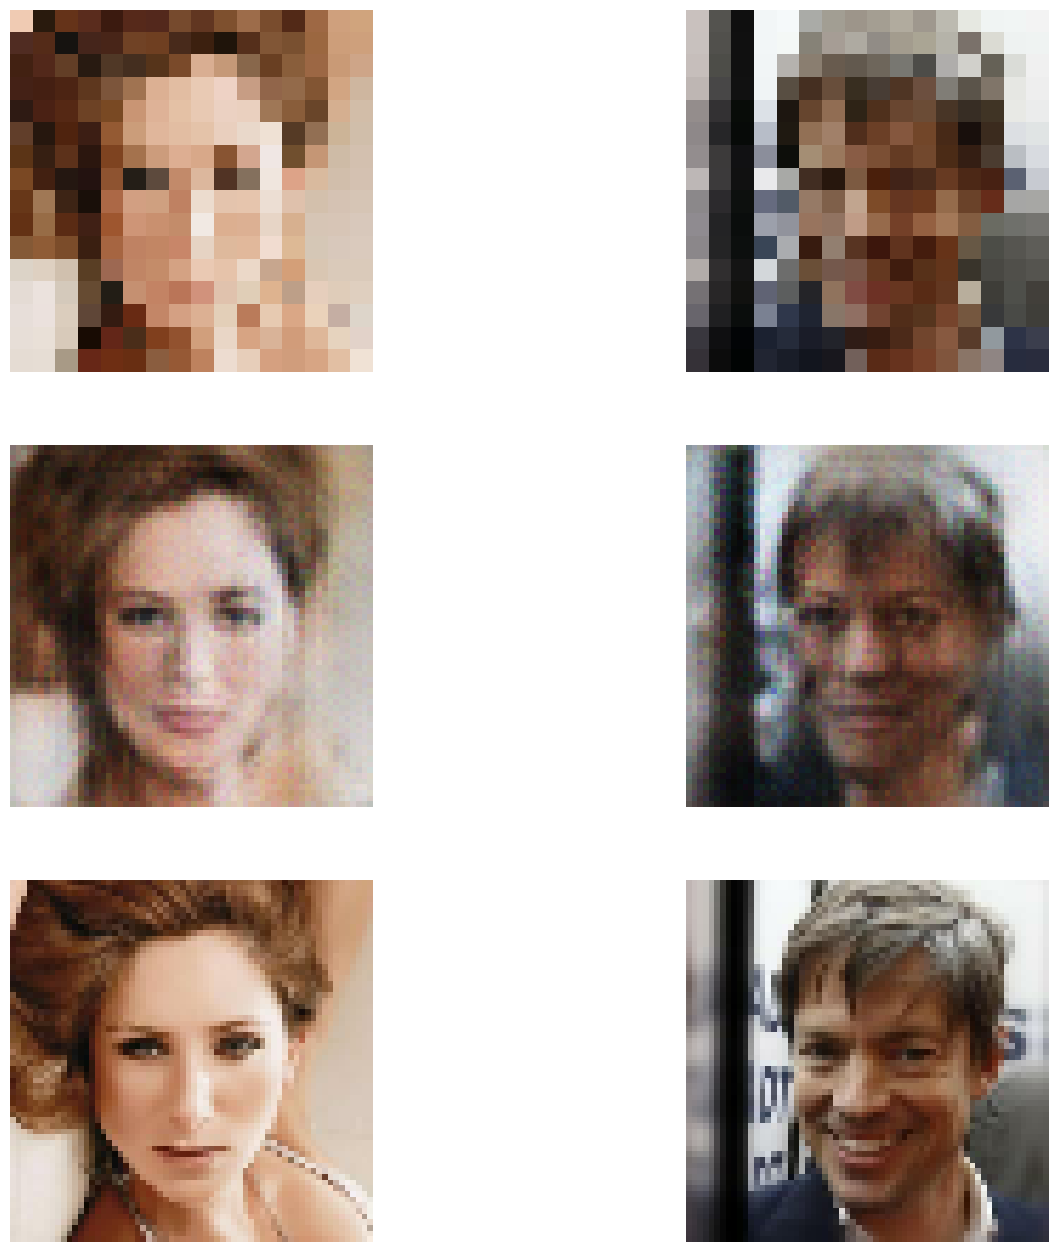

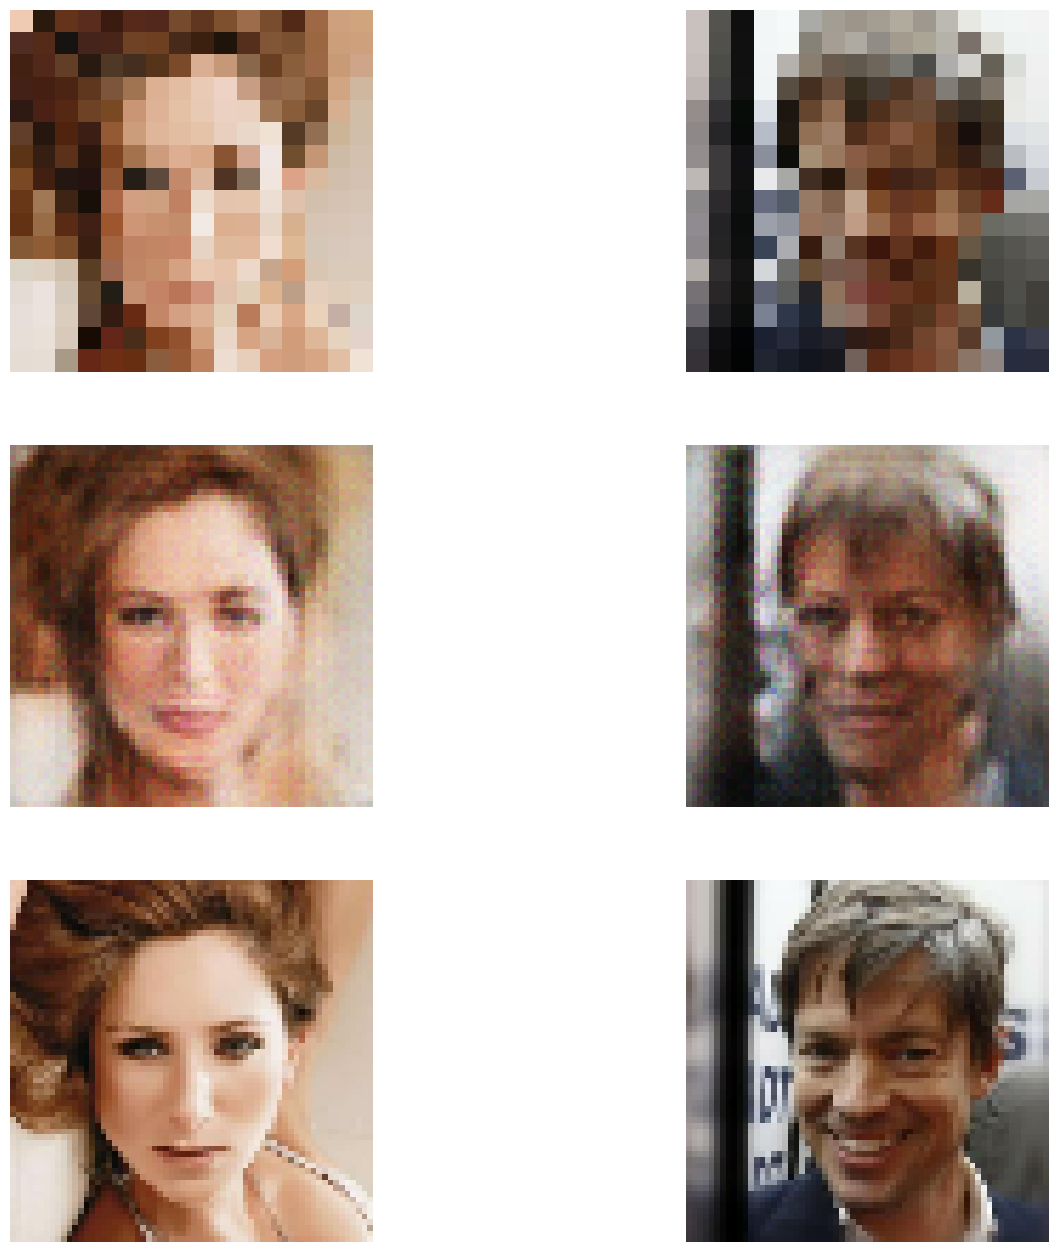

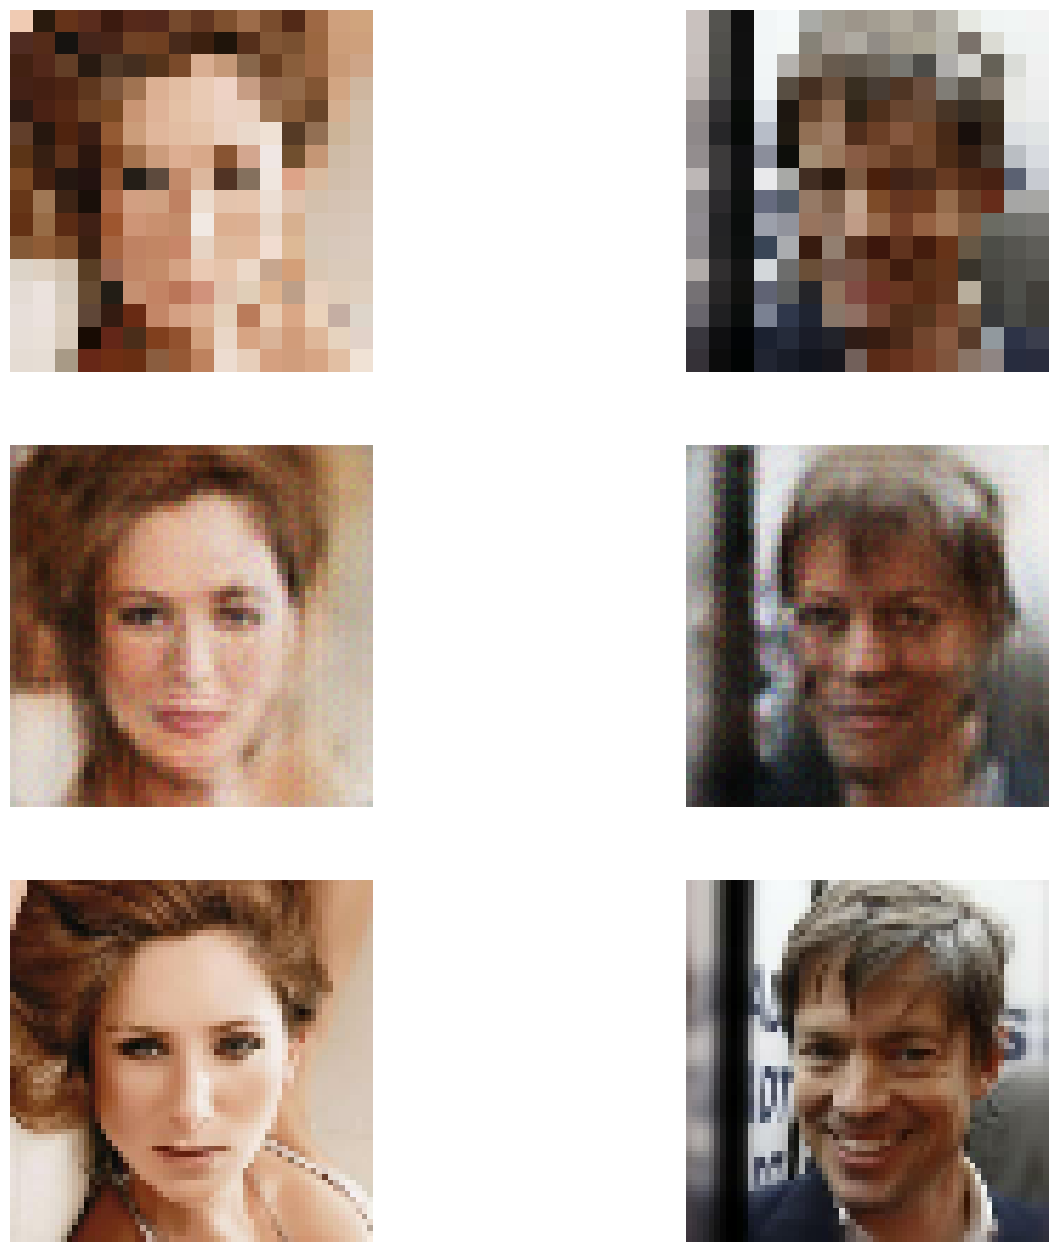

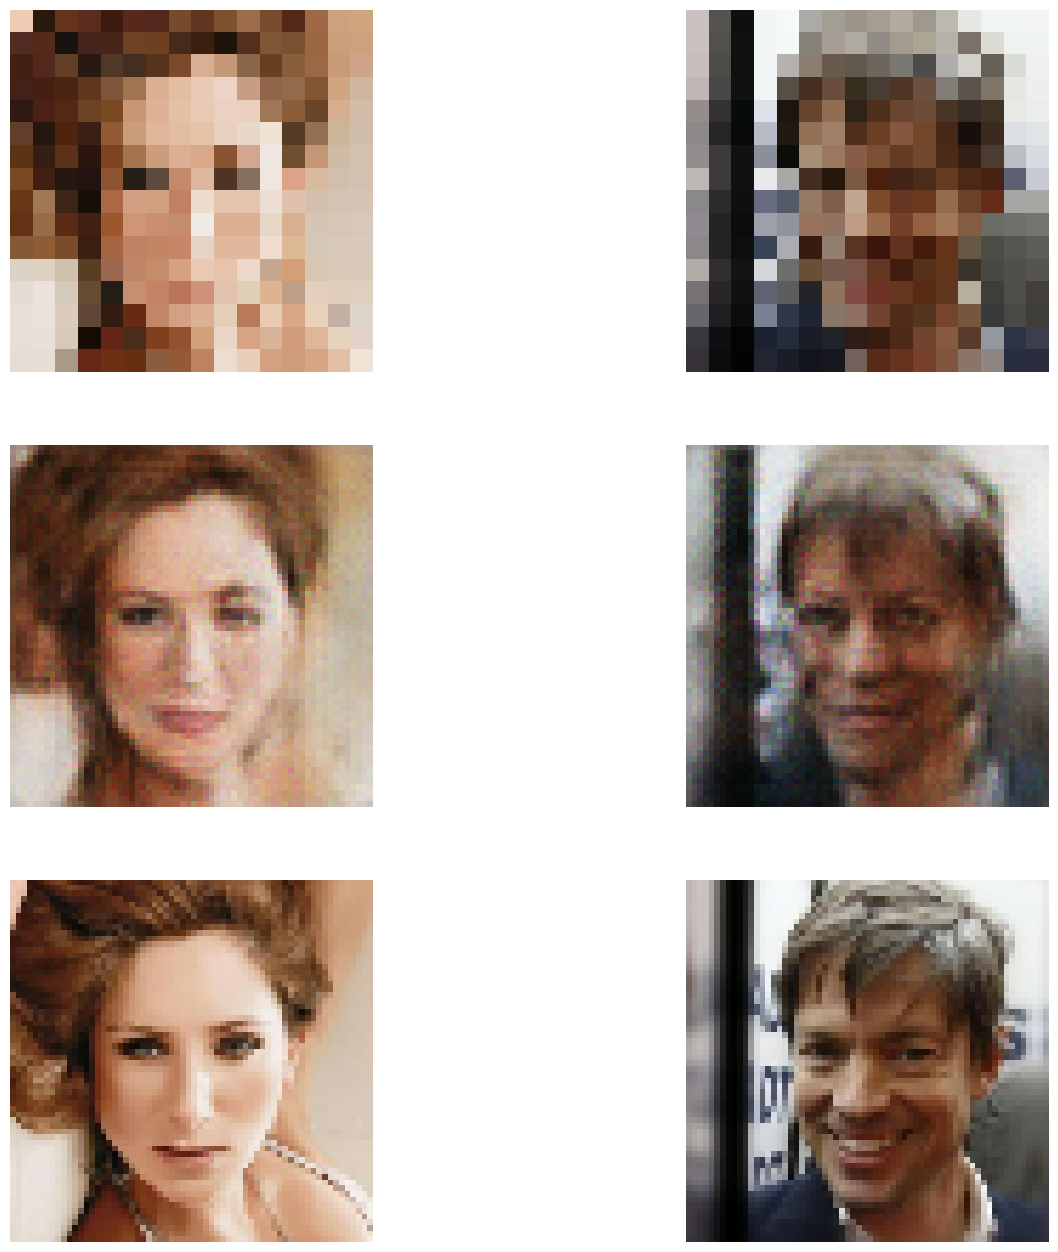

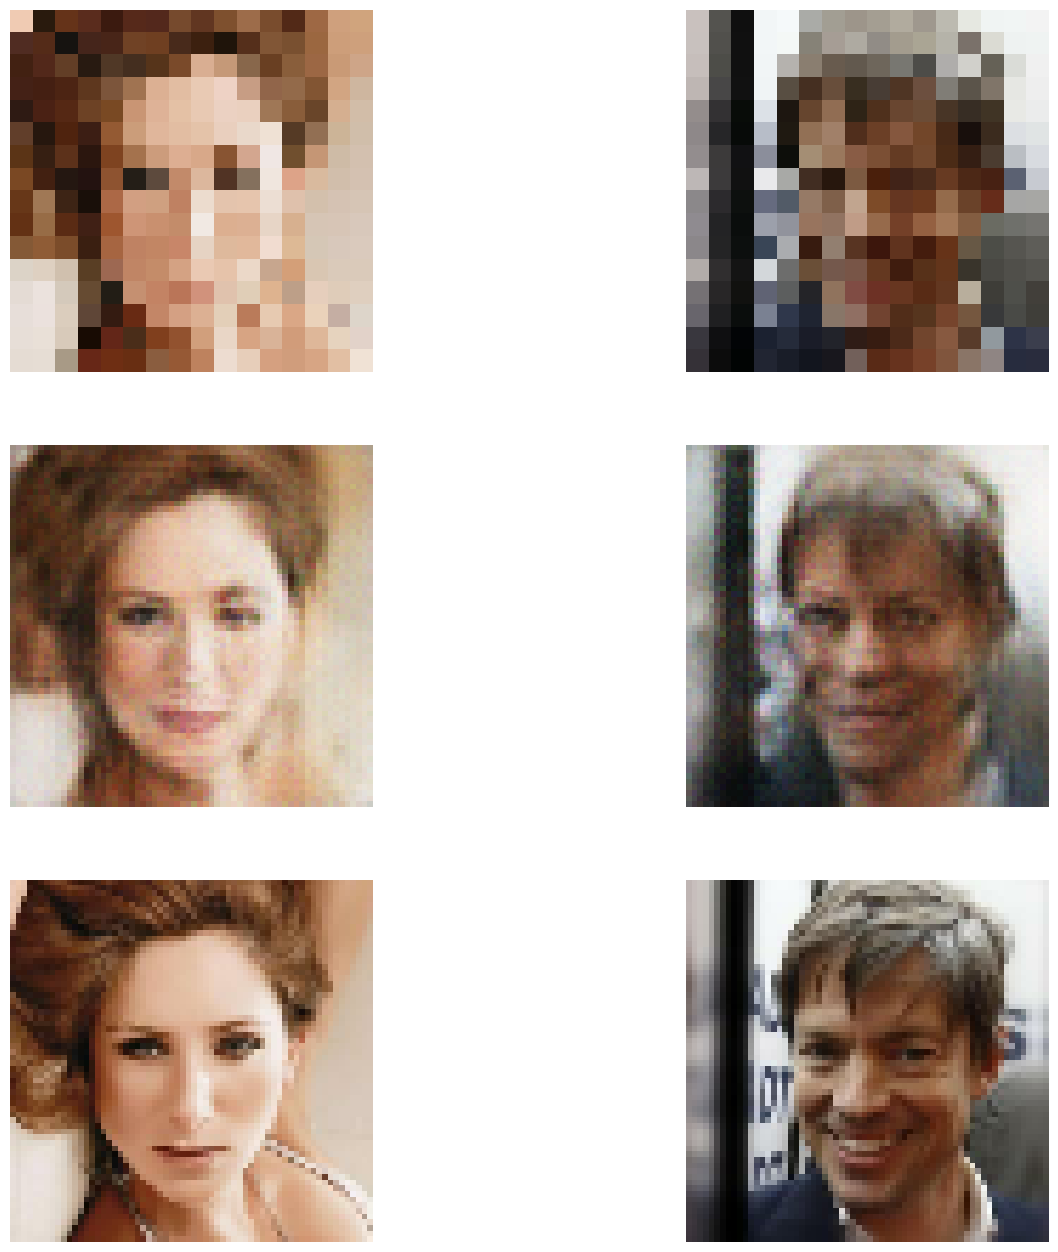

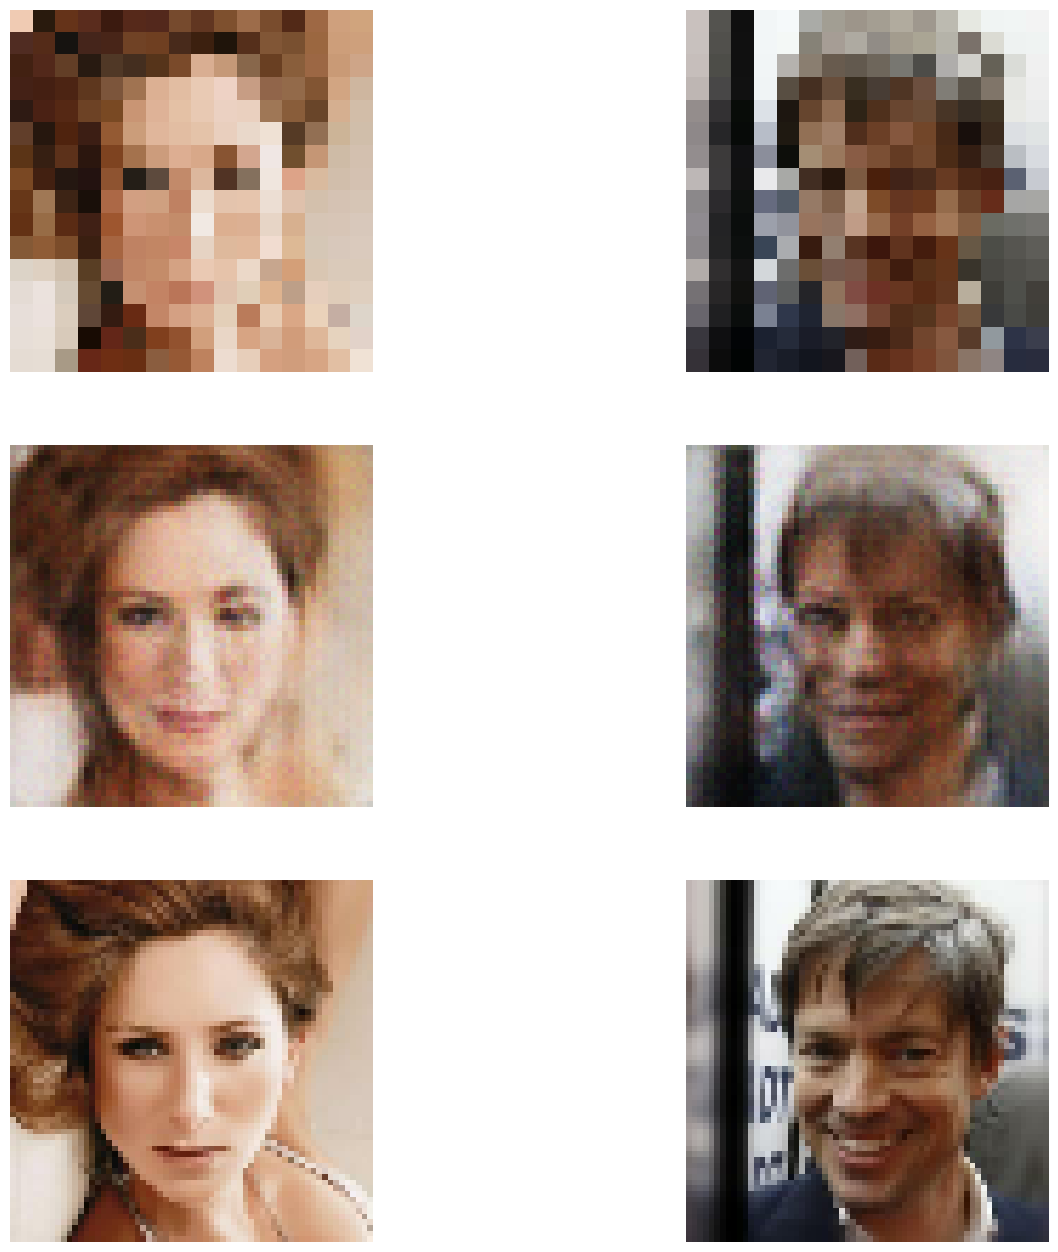

In [ ]:
history=gan.fit(
    train_dataset, epochs=10, callbacks=[GANMonitor()]
)

# History

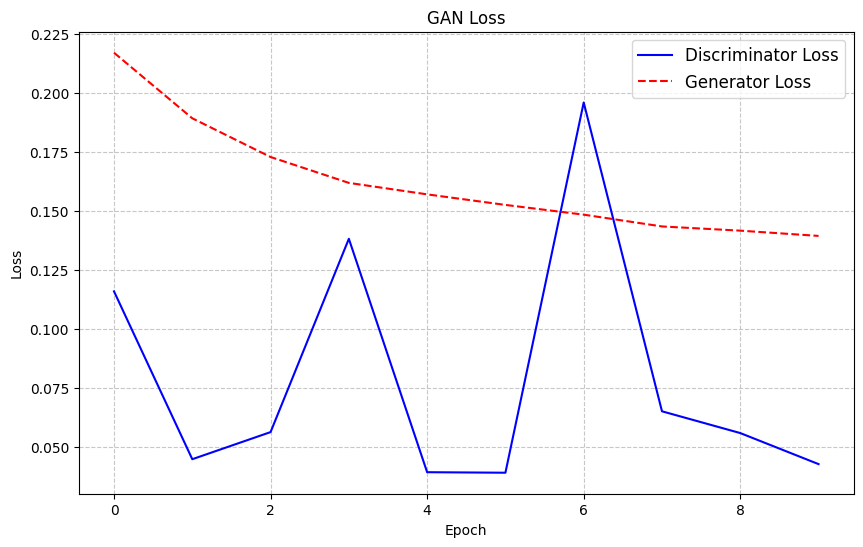

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['d_loss'], label='Discriminator Loss', linestyle='-', color='b')
plt.plot(history.history['g_loss'], label='Generator Loss', linestyle='--', color='r')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize='large')
plt.grid(True, linestyle='--', alpha=0.7)

In [ ]:
from PIL import Image
import os

images_folder = "/content/generated"
gif_filename = "Colorization_Images.gif"

images = []
for filename in sorted(os.listdir(images_folder)):
  if filename.endswith(".png"):
    filepath = os.path.join(images_folder, filename)
    img = Image.open(filepath)
    images.append(img)

images[0].save(gif_filename, save_all=True,
              append_images=images[1:],
              duration=50,
              loop=0)

# Saving and Loading model

In [ ]:
gan.generator.save("srgan_model")
loaded_model = tf.keras.models.load_model("srgan_model")

In [ ]:
image_path = "/content/dataset/celeba_hq_256/00000.jpg"
IMG_SHAPE = (64, 64, 3)
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SHAPE[0] // 4, IMG_SHAPE[1] // 4], method='bicubic'), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
output = loaded_model(image)
plt.imshow((output[0]+1)/2)

# Hugging Face Model

In [3]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 3.0 MB/s eta 0:00:00


In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = gan.generator, repo_id = "DriveMyScream/Image_SuperResolution")

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/192k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

saved_model.pb:   0%|          | 0.00/3.43M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/Image_SuperResolution/tree/main/'

In [ ]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Image_SuperResolution")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

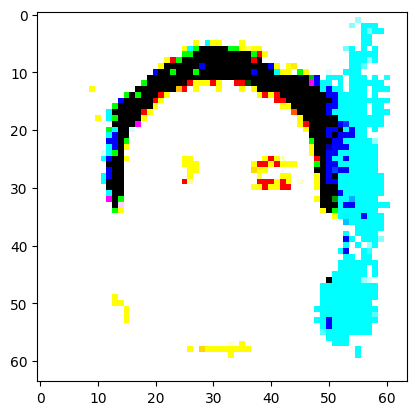

In [10]:
image_path = "/content/dataset/celeba_hq_256/00000.jpg"
IMG_SHAPE = (64, 64, 3)
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SHAPE[0] // 4, IMG_SHAPE[1] // 4], method='bicubic'), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
output = loaded_model(image)
plt.imshow((output[0]+1)/2)

# Tensorflow Lite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(gan.generator)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Image_SuperResolution.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
model_path = "/content/Image_SuperResolution.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
image_path = "/content/dataset/celeba_hq_256/00000.jpg"
IMG_SHAPE = (64, 64, 3)
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SHAPE[0] // 4, IMG_SHAPE[1] // 4], method='bicubic'), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
output = loaded_model(image)
plt.imshow((output[0]+1)/2)

In [ ]:
! cp -r /content/srgan_model /content/drive/MyDrive